In [22]:
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from LogReader import LogHandler

In [23]:
def post_rotate(ydata):
    from scipy.optimize import minimize_scalar
    def rotate_complex(iq, angle):
        return (iq) * np.exp(1j * np.pi * angle/180)

    def std_q(y, rot_agl_):
        iq = rotate_complex(y, rot_agl_)
        return np.std(iq.imag)
    res = minimize_scalar(lambda agl:std_q(ydata, agl), bounds=[0, 360])
    rotation_angle = res.x
    ydata = np.real(rotate_complex(ydata,rotation_angle))
    return ydata

## decay sine

def decaysine_resid(params, xdata, ydata = None, std = None):
    
    amp = params['amp'].value
    freq = params['freq'].value
    phase = params['phase'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp * np.sin(2*np.pi*freq*xdata + phase) * np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def decaysine_guess(xdata, ydata):
    fourier = np.fft.fft(ydata)
    fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
    fft_phases = np.angle(fourier)
    sorted_fourier = np.sort(fourier)
    max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
    if max_ind == 0:
        max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
    max_freq = np.abs(fft_freqs[max_ind])
    max_phase = fft_phases[max_ind]

    yrange = np.max(ydata) - np.min(ydata)
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        amp = dict(value = yrange/2, min = 0.25*yrange, max = 2*yrange),
        freq = dict(value = max_freq, min = 0.1/xrange, max = 15/xrange),
        decay = dict(value = xrange/4, min = 0.0001),
        phase = dict(value = max_phase, min = -np.pi, max = np.pi),
        offset = dict(value = np.mean(ydata), min = np.min(ydata), max = np.max(ydata))
    )
    return params

def expdecay_resid(params, xdata, ydata = None):
    amp = params['amp'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp*np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def expdecay_guess(xdata, ydata):
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        amp = dict(value = ydata[0] - ydata[1]),
        decay = dict(value = xrange/4, min = 0),
        offset = dict(value = ydata[-1])
    )
    return params

In [24]:
log = LogHandler(r'C:\Users\SQC\Desktop\ZCU\ZCU_Data\Test049[02]\2023\11\Data_1126\Test049_T1_008@1.085mA.hdf5')
x,_,y,xname,_,yname = log.output()
y = post_rotate(y[97])
# y = np.abs(y[0])
# y = np.angle(y[0])
x=x*1e6

# model1 = lmfit.Minimizer(decaysine_resid,decaysine_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
model1 = lmfit.Minimizer(expdecay_resid,expdecay_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
o1 = model1.minimize(method = 'leastsq')
lmfit.report_fit(o1)
r_squared = 1- (o1.residual.var()/np.var(y))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 21
    # variables        = 3
    chi-square         = 0.00775069
    reduced chi-square = 4.3059e-04
    Akaike info crit   = -159.994404
    Bayesian info crit = -156.860837
[[Variables]]
    amp:     1.14519149 +/- 0.02883046 (2.52%) (init = 0.02984705)
    decay:   27.5717174 +/- 1.18025478 (4.28%) (init = 76.55694)
    offset: -2.00430799 +/- 0.00782738 (0.39%) (init = -2.015113)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)    = -0.7563
    C(decay, offset) = -0.6010


Text(0.95, 0.95, '$T_1$ = 27.57+/-1.18 $\\mu$s\n    $R^2$ = 0.995')

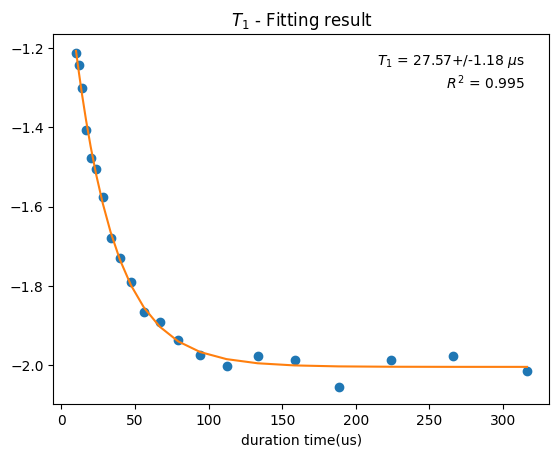

In [25]:
fig, ax = plt.subplots()
plt.ticklabel_format(style = 'sci', scilimits = (-3, 3))
ax.set_title('$T_1$ - Fitting result')
ax.set_xlabel('duration time(us)')

ax.plot(x,y,'o',x,y+o1.residual)
textstr = \
    f"$T_1$ = {o1.uvars['decay']:.2f} $\mu$s\n\
    $R^2$ = {r_squared:.3f}"
ax.text(0.95, 0.95, textstr, transform = ax.transAxes, va = 'top', ha = 'right')

import uncertainties.unumpy as unp

loop T1 -> decay
    unp.nominal_values(x)
    unp.std_devs(x)
    append T1, err

In [26]:
import uncertainties.unumpy as unp
# log = LogHandler()
x,_,y,xname,_,yname = log.output()
x*=1e6

In [27]:
result = []
for i, ydata in enumerate(y):
    ydata = post_rotate(ydata)
    model1 = lmfit.Minimizer(expdecay_resid,expdecay_guess(x,ydata), fcn_args = (x,), fcn_kws={'ydata': ydata})
    o1 = model1.minimize(method = 'powell')
    result.append(o1.uvars['decay'])
T1_result = unp.nominal_values(result)
T1_err = unp.std_devs(result)
    

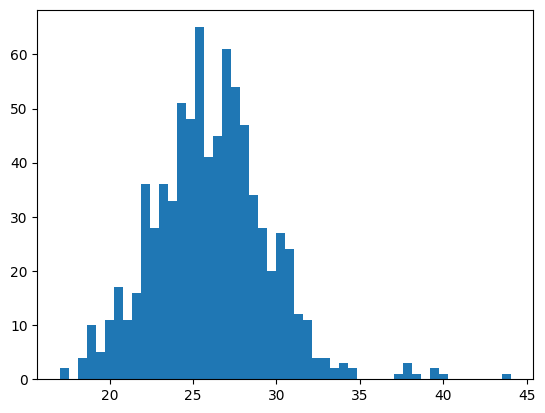

In [31]:
plt.hist(T1_result,50)
plt.show()

<ErrorbarContainer object of 3 artists>

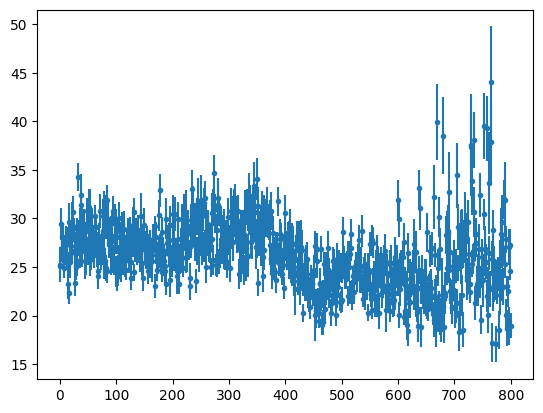

In [29]:
# plt.plot(T1_result,'.')
plt.errorbar(np.arange(len(T1_result)),T1_result,yerr = T1_err,marker='.',linestyle='none')

In [30]:
np.argmax(T1_result)

764